# Modelo de Ising (el problema de Onsanger)

Aquino Chapa Martha Abril

In [1]:
using Plots
using Roots
using BenchmarkTools
using Statistics

In [2]:
#También declaramos las constantes
#definimos la constante de boltzman como 1 para que los resultados tengan mejor visualización
kb = 1
#Se declara con ese valor J por consenso del grupo :)
J=0.5;

Iniciamos creando la red cuadrada de $N^2$ elementos, la cual en vez de presentarla como una matriz será un arreglo

$$RED = [1,2,3,...,N^2] $$

In [3]:
#función que genera una red considerando de manera aleatoria los elememtos de la red: -1 o 1
#El total de elementos en la red es N^2
function generador_de_red(N)
    return  [rand([-1,1]) for i in 1:N^2]
end

generador_de_red (generic function with 1 method)

In [4]:
#Probando la función:
N_prueba=3 
red_prueba = generador_de_red(N_prueba)

9-element Array{Int64,1}:
 -1
  1
  1
 -1
 -1
  1
 -1
 -1
 -1

Ahora generamos un arreglo en el cual en cada fila se encuentren acomodados los vecinos del i-ésimo elemento. 
Estarán acomodados de la siguiente manera: [vecino de arriba, vecino de la derecha, vecino de abajo, vecino de la izquierda]

In [4]:
function generador_indice_vecinos(red)
    N² = length(red)
    N= Int((N²)^(1/2))
    v = zeros(Int64,(N²,4))
    #v[i] = [arriba, derecha, abajo, izquierda]

    #Obtenemos el arreglado donde acomodamos los sitios de los vecinos
    
    #Iniciamos a indexar los vecinos de arriba
    for j in 1:N²
        if j+N<= N²
            v[j,1] = j+N 

        elseif j+N>N²
            v[j,1] = j - N*(N-1)
        end

        #Para los vecinos de la derecha
        if j%N != 0 
            v[j,2] = j+1
        elseif j%N ==0
            v[j,2] = j-N+1 
        end


        #Para los vecinos de abajo

        if j-N>=1
            v[j,3] = j-N
        elseif j-N<1
            v[j,3] =j+N*(N-1)
        end

        #Para los vecinos izquierda

        if (j-1)%N != 0
            v[j,4] = j-1
        elseif (j-1)%N ==0
            v[j,4] = j+N-1
        end
    end
    #Regresamos el arreglo donde están los vecinos
    return v
end

generador_indice_vecinos (generic function with 1 method)

In [6]:
#Probando la función con la red de prueba
vecinos_prueba = generador_indice_vecinos(red_prueba)

9×4 Array{Int64,2}:
 4  2  7  3
 5  3  8  1
 6  1  9  2
 7  5  1  6
 8  6  2  4
 9  4  3  5
 1  8  4  9
 2  9  5  7
 3  7  6  8

En el modelo de Ising considerando geometría cuadrada se tiene que la energía de interacción de un elemento con sus vecinos está dada por
$$E= -J\sum_{<ij>}S_iS_j $$

Por lo que la energía de un elemento se calcula con la siguiente función

Creamos una función que nos devuelva la energía total del sistema 

In [5]:
function energia_total_del_sistema(red_lista)
    #Generamos los indices de los vecinos
    vecinos_lista = generador_indice_vecinos(red_lista)
    #Creamos un arreglo donde iremos sumando cada elemento de la suma de la energía total
    energia_total = 0
    #Creamos un arreglo que obtenga la energía de interacción de cada elemento de la red
    for i in 1:length(red_lista)
        #Obtenemos los indices de los vecinos del elemento i
        vecinosi= vecinos_lista[i,:]
        for j in vecinosi
            energia_total += red_lista[i]*red_lista[j]
        end
    
    end
    return energia_total*(-J)
end

energia_total_del_sistema (generic function with 1 method)

In [10]:
energia_total_del_sistema(red_prueba)

-2.0

### Implementando el algoritmo de Metropolis

Generando el algoritmo de Metropolis
$$\frac{p_i}{p_j} = e^{(-\beta(E_i-E_j))} $$
y queremos encontrar el estado de equilibrio

In [64]:
#Función que modifica la red para evolucionarla a una red en equilibrio con mayor probabilidad
#Inicia recopilando la red y la temperatura y define Q como 5000 iteraciones por default
function ising(red_inicial,T,Q=5000) 
    #Obtenemos la longitud de la red
    N² = length(red_inicial)
    #hacemos una copia de la red
    red_inicial = copy(red_inicial)
    #Definimos dos arreglos donde se vaya anexando la energia total del sistema i
    E = []
    #La magnetización del i-ésimo sistema
    M = []
    #Un conteo de los volteos de spines
    flips = []
    #Obtenemos los vecinos de la red, como esto sólo nos da los indices de la red no es necesario cambiar su valor
    #en cada iteración
    vecinos = generador_indice_vecinos(red_inicial)
    #Un contador del número de volteos hasta la iteración i
    flips_contador = 0
    #Iniciamos las iteraciones
    for i in 1:Q
        #Definimos el elemento al que se le cambiará el spin aleatoriamente 
        j = Int(rand(1:length(red_inicial)))
        #Obtenemos los indices de los vecinos del elemento de la red j
        vecinosj = vecinos[j,:]
        #Obtenemos el spin inicial de la red 
        spin_inicial = red_inicial[j] 
        #calculamos la energía inicial de ese spin
        energia_inicial =  0 
        for k in vecinosj
            energia_inicial += spin_inicial*red_inicial[k]
        end
        #hacemos una copia de la red inicial
        red_final = copy(red_inicial)
        #La propuesta para cambiar el spin
        spin_final = spin_inicial*(-1)
        #le cambiamos el j-ésimo elemento en la nueva red
        red_final[j] = spin_final
        #se obtiene la del spin modificado
        energia_final = 0 
        for k in vecinosj
            energia_final += spin_final*red_final[k]
        end
        #obtemos la diferencia de energia entre el spin modificado y espin sin modificar
        dE= energia_final-energia_inicial
        #si las condiciones se cumplen que se cambie un elemento en la red inicial
        #se cuente la energía del sistema, su magnetización el número de flips en los spines
        if dE<0
            red_inicial[j] = spin_final 
            append!(E,energia_total_del_sistema(red_final))
            append!(M,sum(red_final))
            #sumamos que sí hubo un volteo
            flips_contador +=1
            append!(flips,flips_contador)
        elseif (rand()<exp(-dE/T))
            red_inicial[j] = spin_final
            energia_push = energia_total_del_sistema(red_final)
            #push
            append!(E,energia_push)
            append!(M,sum(red_final))
            flips_contador +=1
            append!(flips,flips_contador)
        end
    end
    #que la función nos regrese los flips, las energias totales y la magnetizacion
    return flips, E, M
end

ising (generic function with 2 methods)

In [61]:
## generando mallas frías para ver en cuantos volteos se termalizan
malla_20x20 = [1 for i in  1:20^2]
flips_20 , energias_20, M_20 = ising(malla_20x20,1.5)

malla_40x40 = [1 for i in  1:40^2]
flips_40 , energias_40, M_40 = ising(malla_40x40,1.5)

malla_50x50 = [1 for i in  1:50^2]
flips_50 , energias_50, M_50 = ising(malla_50x50,1.5)

malla_100x100 = [1 for i in  1:100^2]
flips_100 , energias_100, M_100 = ising(malla_100x100,1.5);


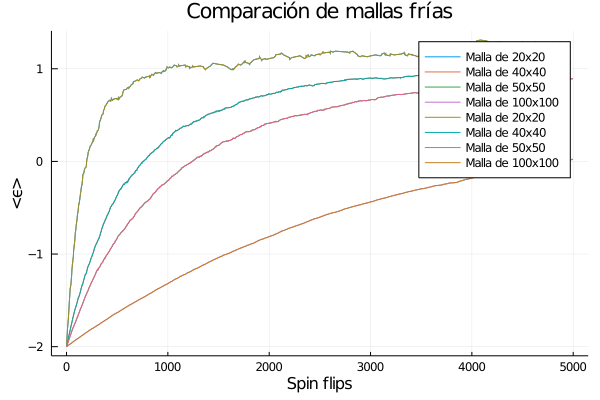

In [65]:
plot!(flips_20, energias_20./20^2,label = "Malla de 20x20")
plot!(flips_40, energias_40./40^2,label = "Malla de 40x40")
plot!(flips_50, energias_50./50^2,label = "Malla de 50x50")
plot!(flips_100, energias_100./100^2,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<ϵ>", title = "Comparación de mallas frías")

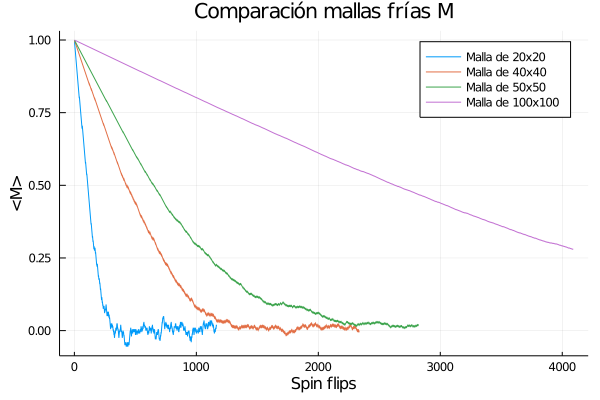

In [40]:
plot!(flips_20, M_20./20^2,label = "Malla de 20x20")
plot!(flips_40, M_40./40^2,label = "Malla de 40x40")
plot!(flips_50, M_50./50^2,label = "Malla de 50x50")
plot!(flips_100, M_100./100^2,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<M>", title = "Comparación mallas frías M")

:o el sistema tarda más en entrar en equilibrio cuando comenzamos con mayor número de spines.
Lo cual tiene sentido si consideramos que para un sistema más grande debemos hacer más cambios en sus spines para que llegue al equilibrio, además, a menor cantidad de spines las fluctiaciones son mayores. Esto último es más fácil visualizarlo en la termalización.

In [41]:
#ahora probando con mallas calientes
malla_20x20_c = [rand([1,-1]) for i in  1:20^2]
flips_20_c , energias_20_c, M_20_c = ising(malla_20x20_c,1.5)

malla_40x40_c = [rand([1,-1]) for i in  1:40^2]
flips_40_c , energias_40_c, M_40_c = ising(malla_40x40_c,1.5)

malla_50x50_c = [rand([1,-1]) for i in  1:50^2]
flips_50_c , energias_50_c, M_50_c = ising(malla_50x50_c,1.5)

malla_100x100_c = [rand([1,-1]) for i in  1:100^2]
flips_100_c , energias_100_c, M_100_c = ising(malla_100x100_c,1.5);

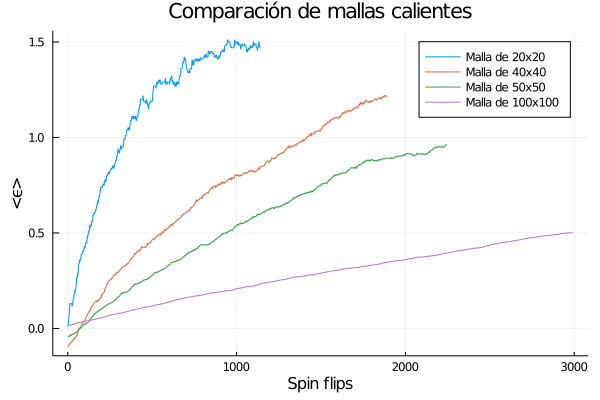

In [45]:
plot!(flips_20_c, energias_20_c./20^2,label = "Malla de 20x20")
plot!(flips_40_c, energias_40_c./40^2,label = "Malla de 40x40")
plot!(flips_50_c, energias_50_c./50^2,label = "Malla de 50x50")
plot!(flips_100_c, energias_100_c./100^2,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<ϵ>", title = "Comparación de mallas calientes")
plot!()

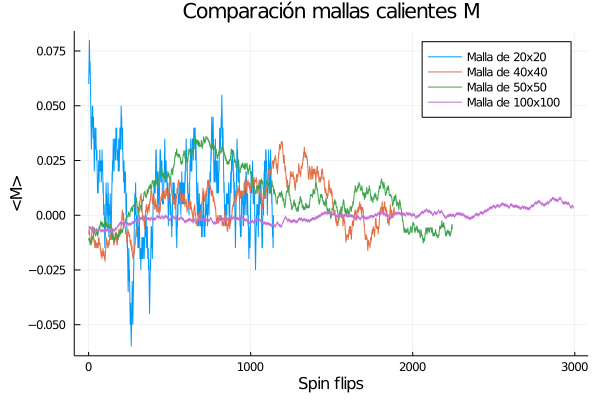

In [48]:
plot!(flips_20_c, M_20_c./20^2,label = "Malla de 20x20")
plot!(flips_40_c, M_40_c./40^2,label = "Malla de 40x40")
plot!(flips_50_c, M_50_c./50^2,label = "Malla de 50x50")
plot!(flips_100_c, M_100_c./100^2,label = "Malla de 100x100")
plot!(xlabel = "Spin flips", ylabel ="<M>", title = "Comparación mallas calientes M")

Comparando ahora mallas frías y calientes

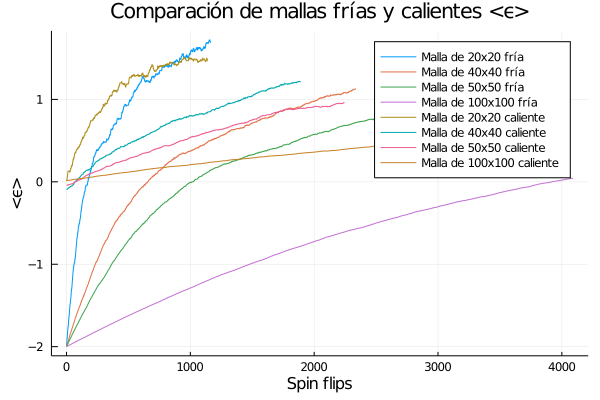

In [51]:
plot!(flips_20, energias_20./20^2,label = "Malla de 20x20 fría")
plot!(flips_40, energias_40./40^2,label = "Malla de 40x40 fría")
plot!(flips_50, energias_50./50^2,label = "Malla de 50x50 fría")
plot!(flips_100, energias_100./100^2,label = "Malla de 100x100 fría")

plot!(flips_20_c, energias_20_c./20^2,label = "Malla de 20x20 caliente")
plot!(flips_40_c, energias_40_c./40^2,label = "Malla de 40x40 caliente")
plot!(flips_50_c, energias_50_c./50^2,label = "Malla de 50x50 caliente")
plot!(flips_100_c, energias_100_c./100^2,label = "Malla de 100x100 caliente")
plot!(xlabel = "Spin flips", ylabel ="<ϵ>", title = "Comparación de mallas frías y calientes <ϵ>")

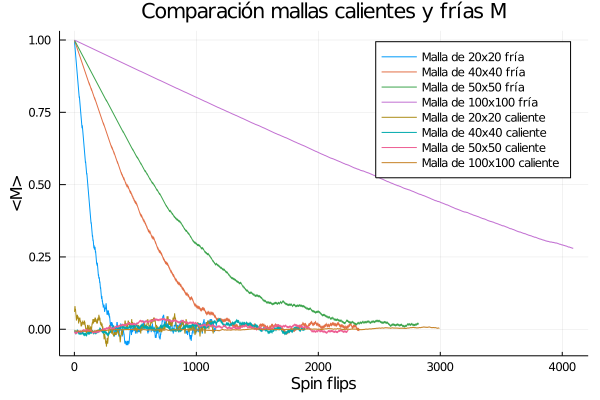

In [53]:
plot!(flips_20, M_20./20^2,label = "Malla de 20x20 fría")
plot!(flips_40, M_40./40^2,label = "Malla de 40x40 fría")
plot!(flips_50, M_50./50^2,label = "Malla de 50x50 fría")
plot!(flips_100, M_100./100^2,label = "Malla de 100x100 fría")

plot!(flips_20_c, M_20_c./20^2,label = "Malla de 20x20 caliente")
plot!(flips_40_c, M_40_c./40^2,label = "Malla de 40x40 caliente")
plot!(flips_50_c, M_50_c./50^2,label = "Malla de 50x50 caliente")
plot!(flips_100_c, M_100_c./100^2,label = "Malla de 100x100 caliente")
plot!(xlabel = "Spin flips", ylabel ="<M>", title = "Comparación mallas calientes y frías M")

Como ya habíamos dicho a mayor número de spines menos son las oscilasciones; sin embargo lo mismo puede verse que si se toma una malla fría oscilan menos que las calientes.

## Termalizando mallas calientes 

In [7]:
### Copiamos la función Ising que se tiene anteriormente pero ahora dejando como parámetro el número de iteraciones
#Función que modifica la red para evolucionarla a una red en equilibrio con mayor probabilidad
#Inicia recopilando la red y la temperatura y define Q como 5000 iteraciones por default
function ising_Q(red_inicial,T,Q) 
    #Obtenemos la longitud de la red
    N² = length(red_inicial)
    #hacemos una copia de la red
    red_inicial = copy(red_inicial)
    #Definimos dos arreglos donde se vaya anexando la energia total del sistema i
    E = []
    #La magnetización del i-ésimo sistema
    M = []
    #Un conteo de los volteos de spines
    flips = []
    #Obtenemos los vecinos de la red, como esto sólo nos da los indices de la red no es necesario cambiar su valor
    #en cada iteración
    vecinos = generador_indice_vecinos(red_inicial)
    #Un contador del número de volteos hasta la iteración i
    flips_contador = 0
    #Iniciamos las iteraciones
    for i in 1:Q
        #Definimos el elemento al que se le cambiará el spin aleatoriamente 
        j = Int(rand(1:length(red_inicial)))
        #Obtenemos los indices de los vecinos del elemento de la red j
        vecinosj = vecinos[j,:]
        #Obtenemos el spin inicial de la red 
        spin_inicial = red_inicial[j] 
        #calculamos la energía inicial de ese spin
        energia_inicial =  0 
        for k in vecinosj
            energia_inicial += spin_inicial*red_inicial[k]
        end
        #hacemos una copia de la red inicial
        red_final = copy(red_inicial)
        #La propuesta para cambiar el spin
        spin_final = spin_inicial*(-1)
        #le cambiamos el j-ésimo elemento en la nueva red
        red_final[j] = spin_final
        #se obtiene la del spin modificado
        energia_final = 0 
        for k in vecinosj
            energia_final += spin_final*red_final[k]
        end
        #obtemos la diferencia de energia entre el spin modificado y espin sin modificar
        dE= energia_final-energia_inicial
        #si las condiciones se cumplen que se cambie un elemento en la red inicial
        #se cuente la energía del sistema, su magnetización el número de flips en los spines
        if dE<0
            red_inicial[j] = spin_final 
            append!(E,energia_total_del_sistema(red_final))
            append!(M,sum(red_final))
            #sumamos que sí hubo un volteo
            flips_contador +=1
            append!(flips,flips_contador)
        elseif (rand()<exp(-dE/T))
            red_inicial[j] = spin_final
            energia_push = energia_total_del_sistema(red_final)
            append!(E,energia_push)
            append!(M,sum(red_final))
            flips_contador +=1
            append!(flips,flips_contador)
        end
    end
    #que la función nos regrese los flips, las energias totales y la magnetizacion
    return flips, E, M
end

ising_Q (generic function with 1 method)

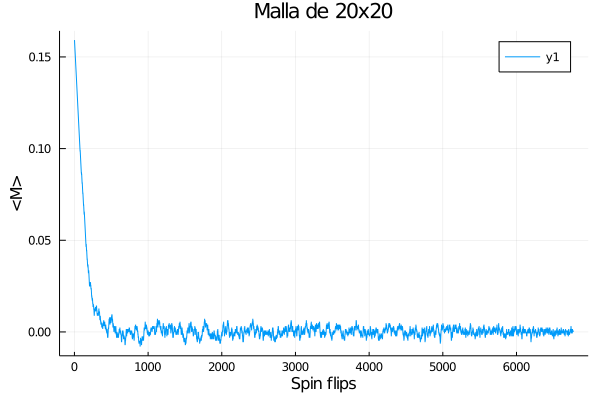

In [71]:
#usamos las mallas frías del inciso anterior para ver cuanto necesitamos para termalizar
Q_20 = 100500
flips_20_Q , energias_20_Q, M_20_Q = ising_Q(malla_20x20,1.5,Q_20)
plot(flips_20_Q, M_20_Q./50^2,xlabel = "Spin flips", ylabel ="<M>",title = "Malla de 20x20")
#plot(flips_20_Q, energias_20_Q./20^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 20x20")

In [73]:
#veamos cuanto tiempo duro esta termalización
@time begin
ising_Q(malla_20x20,1.5,Q_20)
end


  0.427120 seconds (1.28 M allocations: 476.875 MiB, 21.36% gc time)


(Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2657, 2658, 2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666], Any[-792.0, -784.0, -776.0, -768.0, -760.0, -752.0, -744.0, -736.0, -728.0, -720.0  …  764.0, 772.0, 768.0, 772.0, 780.0, 776.0, 768.0, 764.0, 756.0, 748.0], Any[398, 396, 394, 392, 390, 388, 386, 384, 382, 380  …  2, 0, 2, 4, 2, 0, 2, 0, -2, 0])

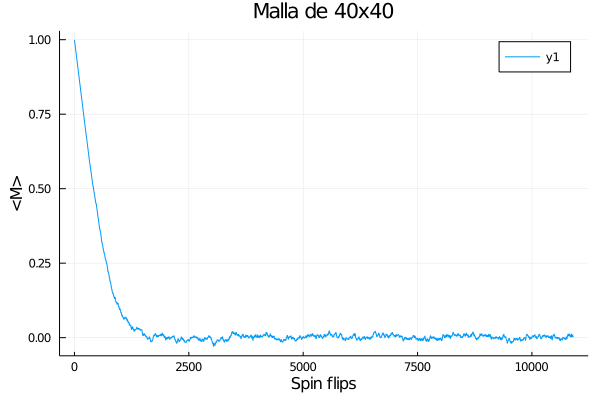

In [75]:
Q_40 = 90000
flips_40_Q , energias_40_Q, M_40_Q = ising_Q(malla_40x40,1.5,Q_40)
#Y graficamos <e> y <m> para ver que el sistema está termalizado
#plot(flips_40_Q, energias_40_Q./40^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 40x40")
plot(flips_40_Q, M_40_Q./40^2,xlabel = "Spin flips", ylabel ="<M>",title = "Malla de 40x40")

In [76]:
#veamos cuanto tiempo duro esta termalización
@time begin
ising_Q(malla_40x40,1.5,Q_40)
end

  2.772330 seconds (19.00 M allocations: 3.608 GiB, 11.03% gc time)


(Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  11700, 11701, 11702, 11703, 11704, 11705, 11706, 11707, 11708, 11709], Any[-3192.0, -3184.0, -3176.0, -3168.0, -3160.0, -3152.0, -3144.0, -3136.0, -3128.0, -3120.0  …  2720.0, 2720.0, 2720.0, 2720.0, 2720.0, 2716.0, 2716.0, 2716.0, 2716.0, 2712.0], Any[1598, 1596, 1594, 1592, 1590, 1588, 1586, 1584, 1582, 1580  …  8, 6, 4, 6, 8, 10, 12, 14, 16, 14])

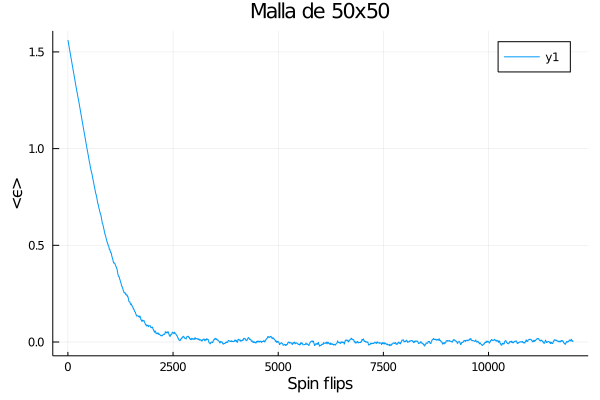

In [78]:
Q_50 = 70000
flips_50_Q , energias_50_Q, M_50_Q = ising_Q(malla_50x50,1.5,Q_50)
#Y graficamos <e> y <m> para ver que el sistema está termalizado
#plot(flips_50_Q, energias_50_Q./40^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 50x50")
plot(flips_50_Q, M_50_Q./40^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 50x50")

In [79]:
@time begin
ising_Q(malla_50x50,1.5,Q_50)
end

  7.816662 seconds (28.92 M allocations: 5.161 GiB, 50.60% gc time)


(Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  11444, 11445, 11446, 11447, 11448, 11449, 11450, 11451, 11452, 11453], Any[-4992.0, -4984.0, -4976.0, -4968.0, -4960.0, -4952.0, -4944.0, -4936.0, -4928.0, -4920.0  …  4304.0, 4304.0, 4304.0, 4304.0, 4304.0, 4304.0, 4304.0, 4312.0, 4312.0, 4308.0], Any[2498, 2496, 2494, 2492, 2490, 2488, 2486, 2484, 2482, 2480  …  4, 6, 4, 2, 0, -2, -4, -6, -4, -2])

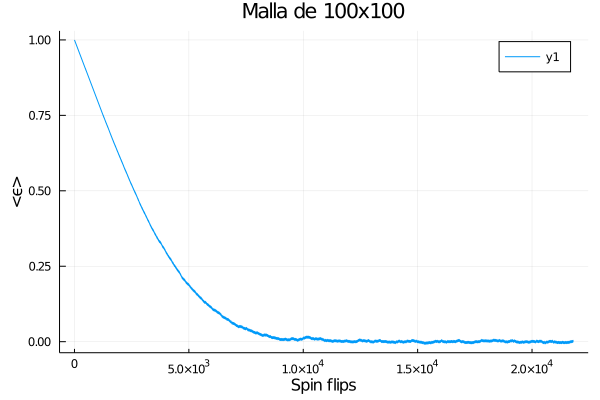

In [86]:
Q_100 =  70000
flips_100_Q , energias_100_Q, M_100_Q = ising_Q(malla_100x100,1.5,Q_100)
#Y graficamos <e> y <m> para ver que el sistema está termalizado
#plot(flips_100_Q, energias_100_Q./100^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 100x100")
plot(flips_100_Q, M_100_Q./100^2,xlabel = "Spin flips", ylabel ="<ϵ>",title = "Malla de 100x100")

In [82]:
@time begin
ising_Q(malla_100x100,1.5,Q_100)
end

 32.751736 seconds (252.15 M allocations: 40.483 GiB, 10.26% gc time)


(Any[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  25161, 25162, 25163, 25164, 25165, 25166, 25167, 25168, 25169, 25170], Any[-19992.0, -19984.0, -19976.0, -19968.0, -19960.0, -19952.0, -19944.0, -19936.0, -19928.0, -19920.0  …  14884.0, 14884.0, 14884.0, 14884.0, 14884.0, 14888.0, 14888.0, 14888.0, 14880.0, 14880.0], Any[9998, 9996, 9994, 9992, 9990, 9988, 9986, 9984, 9982, 9980  …  66, 68, 70, 68, 70, 72, 70, 68, 70, 68])

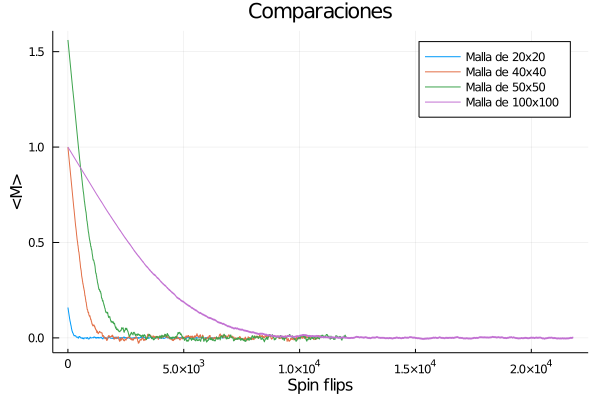

In [91]:
plot!(flips_20_Q, M_20_Q./50^2,label = "Malla de 20x20")
plot!(flips_40_Q, M_40_Q./40^2,label = "Malla de 40x40")
plot!(flips_50_Q, M_50_Q./40^2,label = "Malla de 50x50")
plot!(flips_100_Q, M_100_Q./100^2,label = "Malla de 100x100")
plot!( xlabel = "Spin flips", ylabel ="<M>",title = "Comparaciones")

## Ahora sí a obtener las mediciones

In [6]:
### Copiamos la función Ising que se tiene anteriormente pero ahora dejando como parámetro el número de iteraciones
### Copiamos la función Ising que se tiene anteriormente pero ahora dejando como parámetro el número de iteraciones
#Función que modifica la red para evolucionarla a una red en equilibrio con mayor probabilidad
#Inicia recopilando la red y la temperatura y define Q como 5000 iteraciones por default
function ising_Q_RED(red_inicial,T,Q) 
    #Obtenemos la longitud de la red
    N² = length(red_inicial)
    #hacemos una copia de la red
    red_inicial = copy(red_inicial)
    #Definimos dos arreglos donde se vaya anexando la energia total del sistema i
    E = []
    #La magnetización del i-ésimo sistema
    M = []
    #Un conteo de los volteos de spines
    flips = []
    #Obtenemos los vecinos de la red, como esto sólo nos da los indices de la red no es necesario cambiar su valor
    #en cada iteración
    vecinos = generador_indice_vecinos(red_inicial)
    #Un contador del número de volteos hasta la iteración i
    flips_contador = 0
    #Iniciamos las iteraciones
    for i in 1:Q
        #Definimos el elemento al que se le cambiará el spin aleatoriamente 
        j = Int(rand(1:length(red_inicial)))
        #Obtenemos los indices de los vecinos del elemento de la red j
        vecinosj = vecinos[j,:]
        #Obtenemos el spin inicial de la red 
        spin_inicial = red_inicial[j] 
        #calculamos la energía inicial de ese spin
        energia_inicial =  0 
        for k in vecinosj
            energia_inicial += spin_inicial*red_inicial[k]
        end
        #hacemos una copia de la red inicial
        red_final = copy(red_inicial)
        #La propuesta para cambiar el spin
        spin_final = spin_inicial*(-1)
        #le cambiamos el j-ésimo elemento en la nueva red
        red_final[j] = spin_final
        #se obtiene la del spin modificado
        energia_final = 0 
        for k in vecinosj
            energia_final += spin_final*red_final[k]
        end
        #obtemos la diferencia de energia entre el spin modificado y espin sin modificar
        dE= energia_final-energia_inicial
        #si las condiciones se cumplen que se cambie un elemento en la red inicial
        #se cuente la energía del sistema, su magnetización el número de flips en los spines
        if dE<0
            red_inicial[j] = spin_final 
            append!(E,energia_total_del_sistema(red_final))
            append!(M,sum(red_final))
            #sumamos que sí hubo un volteo
            flips_contador +=1
            append!(flips,flips_contador)
        elseif (rand()<exp(-dE/T))
            red_inicial[j] = spin_final
            energia_push = energia_total_del_sistema(red_final)
            append!(E,energia_push)
            append!(M,sum(red_final))
            flips_contador +=1
            append!(flips,flips_contador)
        end
    end
    #que la función nos regrese los flips, las energias totales y la magnetizacion
    return E[end], M[end]
end

ising_Q_RED (generic function with 1 method)

In [7]:
Q_100 =  70000
@time begin 
    energias_medidas = []
    magnetizacion_medidas = []
    #definimos el rando de temperaturas
    temperaturas = collect(0:0.01:10)
    #Iniciamos con una red fría
    #Iniciamos barriendo por todas las temperaturas
    medidas = 50
    for t in temperaturas 
        energia = []
        magnetizacion = []
        for m in medidas
            malla_t = [1 for i in 1:100^2]
            valores = ising_Q_RED(malla_t,t,Q_100)
            push!(energia, valores[1])
            push!(magnetizacion,valores[2])
        end

        push!(energias_medidas, mean(energia))
        #anexamos la magnetización total 
        push!(magnetizacion_medidas,mean(magnetizacion))
    end
end


30953.321223 seconds (444.52 G allocations: 63.268 TiB, 8.25% gc time)


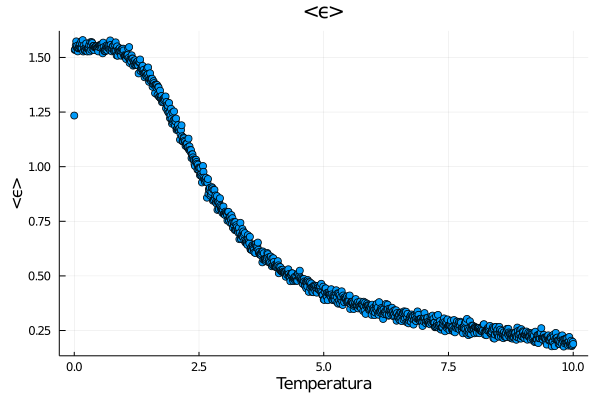

In [14]:
scatter(temperaturas,energias_medidas./100^2,title = "<ϵ>", xlabel = "Temperatura", 
    ylabel = "<ϵ>", label = false)

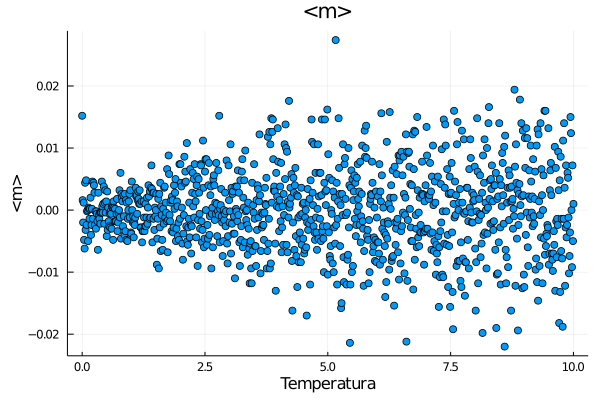

In [12]:
scatter(temperaturas,magnetizacion_medidas./100^2, title = "<m>", xlabel = "Temperatura", 
    ylabel = "<m>", label = false)

In [10]:
using DelimitedFiles 
writedlm("magnetizacion_2.txt",magnetizacion_medidas)
writedlm("energia_2.txt",magnetizacion_medidas)
#tiempo 30953.321223 seconds

Los datos anteriores se obtuvieron de lo siguiente 
Q_100 =  70000
@time begin 
    energias_medidas = []
    magnetizacion_medidas = []
    #definimos el rando de temperaturas
    temperaturas = collect(0:0.01:10)
    #Iniciamos con una red fría
    #Iniciamos barriendo por todas las temperaturas
    medidas = 50
    for t in temperaturas 
        energia = []
        magnetizacion = []
        for m in medidas
            malla_t = [1 for i in 1:100^2]
            valores = ising_Q_RED(malla_t,t,Q_100)
            push!(energia, valores[1])
            push!(magnetizacion,valores[2])
        end

        push!(energias_medidas, mean(energia))
        #anexamos la magnetización total 
        push!(magnetizacion_medidas,mean(magnetizacion))
    end
end


In [ ]:
## writedlm("magnetizacion_1.txt",magnetizacion_medidas)
#para la primera corrida se uso temperaturas = collect(0:0.01:2)
#Con 10 mediciones de cada temperatura

### Calculando cuanto tiempo se tarda en pasar de un estado frío a uno caliente